In [49]:
# Import libraries and dependencies
import os
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import random
import hvplot.pandas
import seaborn as sns

In [2]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
# Set each environment variable to a notebook variable of the same name
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each.
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

In [4]:
# Create your Alpaca API REST object by calling Alpaca's tradeapi.REST function.
# Set the parameters to your alpaca_api_key, alpaca_secret_key and api_version="v2" 
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [5]:
# Gather portfolio preferences from user

risk_score = input("""What's your risk score? Rate from 0 - 10 with 10 being the highest risk preference for the portfolio.
""")

preference_equity = input("""What's your investment strategy preference for equity? 
Type 1 for Dividend Income
Type 2 for Capital Growth
Type 3 for Balanced
""")


preference_fixed_income = input("""What's your investment strategy preference for fixed income?
Type 1 for Higher Risk
Type 2 for Higher Quality
Type 3 for Mixed
""")


time_period = input("""What's your preferred time duration for investment? Enter a number to indicate the number of years.
""")


investment_value = input("""What is the value of your initial investment? Enter a numerical value to indicate the starting dollar amount.
""")

risk_score = int(risk_score)
preference_equity = int(preference_equity)
preference_fixed_income = int(preference_fixed_income)
time_period = int(time_period)
investment_value = int(investment_value)

What's your risk score? Rate from 0 - 10 with 10 being the highest risk preference for the portfolio.
 4
What's your investment strategy preference for equity? 
Type 1 for Dividend Income
Type 2 for Capital Growth
Type 3 for Balanced
 1
What's your investment strategy preference for fixed income?
Type 1 for Higher Risk
Type 2 for Higher Quality
Type 3 for Mixed
 3
What's your preferred time duration for investment? Enter a number to indicate the number of years.
 5
What is the value of your initial investment? Enter a numerical value to indicate the starting dollar amount.
 50000


In [6]:
# Create the list for the required tickers

# equity
tickers_equity_type1 = ["DIA", "DVY", "VNQ"]#dividend income
tickers_equity_type2 = ["QQQ", "VBK", "ARKK"]#capital growth
tickers_equity_type3 = ["SPY", "VXF", "IWM"]#balanced

# income
tickers_income_type1 = ["LQD"]#higher risk
tickers_income_type2 = ["IEI"]#higher quality
tickers_income_type3 = ["AGG"]#mixed

In [7]:
# interest and income of each portfolio by asset type

#equity
tickers_equity_type1_inc = (0.016 + 0.03 + 0.027) / 3
tickers_equity_type2_inc = (0.005 + 0.004 + 0.0) / 3
tickers_equity_type3_inc = (0.012 + 0.012 + 0.01) / 3

#fixed income
tickers_income_type1_inc = 0.025
tickers_income_type2_inc = 0.014
tickers_income_type3_inc = 0.016


In [8]:
# Risk score needs to be converted to asset weights

weight_risk = risk_score/10 
weight_fixed = 1 - weight_risk 

In [9]:
# Assigns an empty list for tickers to be used for equity. If statement from user input determines how list is populated.
# if statement also determines the annual rate of income/interest to be generated from the combined equity assets

equity_tickers = []

if preference_equity == 1:
    equity_tickers = tickers_equity_type1  
    equity_income = tickers_equity_type1_inc
    
elif preference_equity == 2:
    equity_tickers = tickers_equity_type2 
    equity_income = tickers_equity_type2_inc
    
elif preference_equity == 3:
    equity_tickers = tickers_equity_type3 
    equity_income = tickers_equity_type3_inc

else:
    print("You did not enter a valid equity preference. Please try again.")

In [10]:
# Assigns an empty list for tickers to be used for fixed income. If statement from user input determines how list is populated.
# if statement also determines the annual rate of income/interest to be generated from the fixed income asset

fixed_income_tickers = []

if preference_fixed_income == 1:
    fixed_income_tickers = tickers_income_type1
    fixed_income = tickers_income_type1_inc
    
elif preference_fixed_income == 2:
    fixed_income_tickers = tickers_income_type2
    fixed_income = tickers_income_type2_inc
    
elif preference_fixed_income == 3:
    fixed_income_tickers = tickers_income_type3
    fixed_income = tickers_income_type3_inc

else:
    print("You did not enter a valid fixed income preference. Please try again.")

In [11]:
# adds list of two prior function together to form tickers to be in portfolio
tickers = equity_tickers + fixed_income_tickers
tickers

['DIA', 'DVY', 'VNQ', 'AGG']

In [12]:
# computes portfolio income
portfolio_income = (weight_risk * equity_income) + (weight_fixed * fixed_income)
portfolio_income

0.019333333333333334

In [13]:
# Determines weights to be applied to each ETF in the portfolio. For this analysis, assumes equity ETFs will be equal weighted.

weight_equity_1 = weight_risk / 3
weight_equity_2 = weight_risk /3
weight_equity_3 = weight_risk / 3
weight_fixed = 1 - weight_equity_1 - weight_equity_2 - weight_equity_3

weights = [weight_equity_1, weight_equity_2, weight_equity_3, weight_fixed]
weights

[0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.6000000000000001]

In [14]:
# Places portfolio tickers and weights into a dataframe and sorts alphabetically in order to run API call for ticker data

portfolio_df = pd.DataFrame({'tickers': tickers, 'weights': weights})
portfolio_df = portfolio_df.sort_values('tickers')
portfolio_df

,tickers,weights
3,AGG,0.600000
0,DIA,0.133333
1,DVY,0.133333
2,VNQ,0.133333


In [15]:
# recreates tickers list, this time in alphabetical order
tickers = portfolio_df['tickers'].tolist()
tickers

['AGG', 'DIA', 'DVY', 'VNQ']

In [16]:
# recreates weights list, this time, in the same order as the new sorted tickers list
weights = portfolio_df['weights'].tolist()
weights

[0.6000000000000001,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333]

In [17]:
# sets number of trading days for the simulation (time horizon of the investment)
num_trading_days = 252 * time_period

In [18]:
# Set the values for start_date and end_date using the pd.Timestamp function
# Set the parameter tz to "America/New_York", 
# Set this all to the ISO format by calling the isoformat function 
start_date = pd.Timestamp("2018-12-31", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()

In [19]:
# Set timeframe to one day (1D)
timeframe = "1D"

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [20]:
# Use the Alpaca get_barset function to gather the price information for each ticker
# Include the function parameters: tickers, timeframe, start, end, and limit
# Be sure to call the df property to ensure that the returned information is set as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Review the first five rows of the resulting DataFrame 
prices_df.head()

AGG                                        \
                             open     high       low    close    volume   
time                                                                      
2018-12-31 00:00:00-05:00  106.12  106.510  105.6200  106.495   8349838   
2019-01-02 00:00:00-05:00  106.55  106.610  106.4701  106.585  10164756   
2019-01-03 00:00:00-05:00  106.57  107.075  106.5700  107.020   6260265   
2019-01-04 00:00:00-05:00  106.66  106.720  106.5500  106.695   7755476   
2019-01-07 00:00:00-05:00  106.72  106.790  106.4600  106.470   6545877   

                              DIA                                        DVY  \
                             open    high      low     close   volume   open   
time                                                                           
2018-12-31 00:00:00-05:00  232.33  233.22  231.050  231.7700  4600042  89.06   
2019-01-02 00:00:00-05:00  229.27  234.00  229.140  232.9800  4949729  88.29   
2019-01-03 00:00:00-05:00  231.25  231.42  226.621  227.1900  6864028  88.80   
2019-01-04 00:00:00-05:00  230.00  235.18  229.730  234.2401  6976907  88.83   
2019-01-07 00:00:00-05:00  234.84  236.88  232.951  235.3900  3873356  90.41   

                                                                  VNQ  \
                              high      low   close     volume   open   
time                                                                    
2018-12-31 00:00:00-05:00  89.3099  88.3000  88.950  2673934.0  74.31   
2019-01-02 00:00:00-05:00  89.3300  87.8700  88.970  1164455.0  73.56   
2019-01-03 00:00:00-05:00  89.1800  87.9100  88.280   995745.0  72.77   
2019-01-04 00:00:00-05:00  90.4499  88.4201  90.350  1590662.0  73.74   
2019-01-07 00:00:00-05:00  91.5600  89.9500  90.905  1899922.0  74.60   

                                                             
                              high    low   close    volume  
time                                                         
2018-12-31 00:00:00-05:00  74.7200  73.30  74.405  15320211  
2019-01-02 00:00:00-05:00  73.7000  72.53  72.880  10872410  
2019-01-03 00:00:00-05:00  74.5700  72.71  73.430   9963138  
2019-01-04 00:00:00-05:00  75.0200  73.30  74.330   7585079  
2019-01-07 00:00:00-05:00  75.6062  74.40  75.045   7502420

In [21]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
# Use an even weight of .33 across all 3 stocks
MC_even_weight = MCSimulation(
    portfolio_data = prices_df,
    weights = weights,
    num_simulation = 500,
    num_trading_days = num_trading_days
)

# Printing the first five rows of the simulation input data
MC_even_weight.portfolio_data.head()

AGG                                        \
                             open     high       low    close    volume   
time                                                                      
2018-12-31 00:00:00-05:00  106.12  106.510  105.6200  106.495   8349838   
2019-01-02 00:00:00-05:00  106.55  106.610  106.4701  106.585  10164756   
2019-01-03 00:00:00-05:00  106.57  107.075  106.5700  107.020   6260265   
2019-01-04 00:00:00-05:00  106.66  106.720  106.5500  106.695   7755476   
2019-01-07 00:00:00-05:00  106.72  106.790  106.4600  106.470   6545877   

                                           DIA                             \
                          daily_return    open    high      low     close   
time                                                                        
2018-12-31 00:00:00-05:00          NaN  232.33  233.22  231.050  231.7700   
2019-01-02 00:00:00-05:00     0.000845  229.27  234.00  229.140  232.9800   
2019-01-03 00:00:00-05:00     0.004081  231.25  231.42  226.621  227.1900   
2019-01-04 00:00:00-05:00    -0.003037  230.00  235.18  229.730  234.2401   
2019-01-07 00:00:00-05:00    -0.002109  234.84  236.88  232.951  235.3900   

                           ...      DVY                                  \
                           ...      low   close     volume daily_return   
time                       ...                                            
2018-12-31 00:00:00-05:00  ...  88.3000  88.950  2673934.0          NaN   
2019-01-02 00:00:00-05:00  ...  87.8700  88.970  1164455.0     0.000225   
2019-01-03 00:00:00-05:00  ...  87.9100  88.280   995745.0    -0.007755   
2019-01-04 00:00:00-05:00  ...  88.4201  90.350  1590662.0     0.023448   
2019-01-07 00:00:00-05:00  ...  89.9500  90.905  1899922.0     0.006143   

                             VNQ                                    \
                            open     high    low   close    volume   
time                                                                 
2018-12-31 00:00:00-05:00  74.31  74.7200  73.30  74.405  15320211   
2019-01-02 00:00:00-05:00  73.56  73.7000  72.53  72.880  10872410   
2019-01-03 00:00:00-05:00  72.77  74.5700  72.71  73.430   9963138   
2019-01-04 00:00:00-05:00  73.74  75.0200  73.30  74.330   7585079   
2019-01-07 00:00:00-05:00  74.60  75.6062  74.40  75.045   7502420   

                                        
                          daily_return  
time                                    
2018-12-31 00:00:00-05:00          NaN  
2019-01-02 00:00:00-05:00    -0.020496  
2019-01-03 00:00:00-05:00     0.007547  
2019-01-04 00:00:00-05:00     0.012257  
2019-01-07 00:00:00-05:00     0.009619  

[5 rows x 24 columns]

In [22]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
# Create a new variable for the simulation above
sim_df = MC_even_weight.calc_cumulative_return()
sim_df

C:\Users\mwoji\FinTech-Workspace\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996678,1.000227,0.998352,0.995941,1.000203,1.004715,1.001824,1.002167,1.001181,1.007438,...,0.994030,1.006140,1.000855,0.999413,0.999723,0.997539,0.998695,1.003642,1.001471,1.004321
2,0.999509,1.001184,0.995545,0.989757,1.007329,1.003346,1.003456,1.006991,0.999610,1.007948,...,0.993775,1.004736,1.010752,1.003546,1.001064,0.995310,1.001390,1.006893,0.999061,1.001878
3,0.998692,1.008685,0.991072,0.995270,1.006531,1.005652,1.005460,1.010224,1.009317,1.003063,...,0.995466,0.999994,1.009218,1.009641,1.004912,0.988473,1.000842,1.005099,0.997849,1.000427
4,0.998987,1.005052,0.991672,0.999259,1.013204,0.996486,1.004566,1.010835,1.011101,1.005556,...,0.990039,0.998753,1.006639,1.009297,1.010952,0.989761,0.997264,1.007310,0.986021,0.992813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.361927,1.497397,1.531651,1.660821,1.513836,1.433098,1.569114,1.274325,1.451220,1.643737,...,1.437885,1.779062,1.227705,1.286988,1.329383,1.384620,1.315297,1.668569,1.587340,1.471333
1257,1.353965,1.479012,1.517151,1.658797,1.519731,1.435313,1.571624,1.273599,1.457062,1.639577,...,1.439210,1.771382,1.228550,1.284832,1.320285,1.379726,1.319273,1.675983,1.595618,1.480429
1258,1.357326,1.484749,1.514096,1.661807,1.521807,1.430113,1.575199,1.273539,1.453297,1.640261,...,1.438605,1.753254,1.219627,1.289671,1.320726,1.381677,1.326762,1.674388,1.613595,1.482785
1259,1.356059,1.487353,1.506182,1.651596,1.525618,1.438329,1.569285,1.270938,1.446113,1.643370,...,1.432976,1.750893,1.215205,1.280848,1.313942,1.396138,1.333485,1.666718,1.615615,1.489967


In [23]:
# Computes and returns a dataframe for daily price returns of each simulation for each trading day
shift_df = sim_df.shift(-1)
returns_df = (shift_df - sim_df) / sim_df
returns_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.003322,0.000227,-0.001648,-0.004059,0.000203,0.004715,0.001824,0.002167,0.001181,0.007438,...,-0.005970,0.006140,0.000855,-0.000587,-0.000277,-0.002461,-0.001305,0.003642,0.001471,0.004321
1,0.002841,0.000957,-0.002812,-0.006209,0.007125,-0.001363,0.001628,0.004814,-0.001569,0.000507,...,-0.000257,-0.001396,0.009889,0.004135,0.001341,-0.002234,0.002698,0.003240,-0.002406,-0.002432
2,-0.000818,0.007492,-0.004493,0.005570,-0.000792,0.002298,0.001997,0.003211,0.009710,-0.004846,...,0.001702,-0.004719,-0.001518,0.006074,0.003845,-0.006869,-0.000547,-0.001782,-0.001213,-0.001448
3,0.000295,-0.003602,0.000605,0.004008,0.006630,-0.009114,-0.000889,0.000605,0.001767,0.002484,...,-0.005452,-0.001241,-0.002555,-0.000341,0.006010,0.001303,-0.003575,0.002200,-0.011854,-0.007611
4,-0.003544,0.001976,-0.004319,0.006399,-0.004364,-0.003083,-0.002468,-0.003338,0.001864,-0.001247,...,-0.002854,-0.006550,0.003510,-0.000698,-0.000770,-0.004869,-0.006613,-0.001686,-0.004415,-0.002868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,-0.005846,-0.012278,-0.009467,-0.001218,0.003894,0.001545,0.001600,-0.000570,0.004026,-0.002531,...,0.000922,-0.004317,0.000688,-0.001675,-0.006844,-0.003535,0.003022,0.004443,0.005215,0.006182
1257,0.002482,0.003879,-0.002014,0.001815,0.001366,-0.003623,0.002275,-0.000047,-0.002584,0.000417,...,-0.000420,-0.010234,-0.007263,0.003766,0.000334,0.001414,0.005677,-0.000951,0.011267,0.001592
1258,-0.000934,0.001754,-0.005227,-0.006145,0.002504,0.005745,-0.003754,-0.002042,-0.004943,0.001895,...,-0.003913,-0.001346,-0.003626,-0.006841,-0.005136,0.010466,0.005067,-0.004581,0.001252,0.004843
1259,-0.005750,-0.002798,0.000281,0.003250,0.002547,-0.007252,0.005311,0.000299,0.004465,0.002354,...,0.002381,0.008524,0.000195,-0.000467,0.000144,0.001048,0.009884,0.002320,0.001786,0.006345


In [24]:
# Computes the standard deviation of returns for each simulation
annual_std_list = returns_df.std() * (252 **0.5)
annual_std_list

0      0.068201
1      0.067061
2      0.068110
3      0.068896
4      0.066915
         ...   
495    0.069473
496    0.069384
497    0.068658
498    0.069748
499    0.067236
Length: 500, dtype: float64

In [25]:
# and then averages the results to come up with an estimated standard deviation of the portfolio
annual_std = annual_std_list.mean()
annual_std

0.06762471193336073

In [26]:
# Repeats this process to come up with an annual return for each simulation
annual_ret_list = returns_df.mean() * 252
annual_ret_list

0      0.062094
1      0.081098
2      0.084302
3      0.103388
4      0.087239
         ...   
495    0.069371
496    0.061939
497    0.105010
498    0.098748
499    0.083287
Length: 500, dtype: float64

In [27]:
# and then averages the results to come up with an estimated return of the portfolio
annual_ret = annual_ret_list.mean()
annual_ret

0.08075706203013555

In [28]:
#A function to simulate a random set of returns for a portfolio over a desired time horizon given various parameters
def simulate_return(mean_return, standard_dev, portfolio_income, simulated_quarters, number_of_simulations, initial_investment):
    
    #quarterly return of the portfolio plus quarterly income. the mean return could be a call to summary statistics and the annual income to a csv.
    quarterly_ret = (mean_return/4) + (portfolio_income/4)
    
    #quarterly standard deviation of the portfolio. standard deviation could be a call to summary statistics.
    quarterly_stdev = standard_dev / (4**0.5)
    
    #returns a random set of standard deviation multipliers plus the mean return. For example return +/- 1 SD or return +/- (1.65 x Std) to obtain a list of random returns
    quarterly_returns = 1 + np.random.normal(quarterly_ret, quarterly_stdev, (simulated_quarters,number_of_simulations))
    
    #defines the portfolio variable in the same array shape as the previously estimated returns
    portfolio = np.zeros_like(quarterly_returns)
    
    #sets an initial investment for the simulation
    portfolio[0] = initial_investment
    
    #for loop to project out portfolio market value for each simulation
    for t in range (1, simulated_quarters):
        portfolio[t] = (portfolio[t-1]*quarterly_returns[t])
    # Confirm if we want Quantiles or simply each simulation
    return pd.DataFrame(portfolio) #.quantile([.1, .25, .5, .75, .9], axis = 1).T

In [29]:
# determines number of quarters to simulate given years/time horizon
simulated_quarters = time_period * 4

<AxesSubplot:>

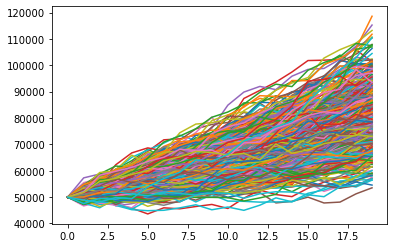

In [30]:
#plot the results. 
simulate_return(annual_ret,annual_std,portfolio_income,simulated_quarters,500,investment_value).plot(legend = None)

In [31]:
# Creates a new variable for the end values of the simulation
ending_values_1 = simulate_return(annual_ret,annual_std,portfolio_income,simulated_quarters,500,investment_value).tail(1)

In [32]:
# Organizes ending values into one column with Trial set to index
ending_values_1 = ending_values_1.T
ending_values_1['trial'] = 1
ending_values_1.columns = ['Ending Values', 'Trial']
ending_values_1.set_index('Trial')


,Ending Values
Trial,
1,82645.628046
1,69507.466194
1,75074.378290
1,82614.465585
1,68258.299464
...,...
1,84219.019335
1,66729.434028
1,78737.859645


<AxesSubplot:ylabel='Frequency'>

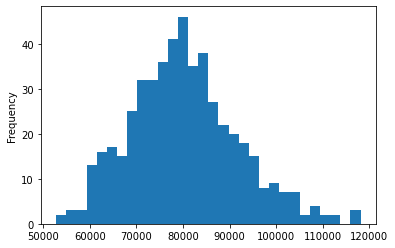

In [33]:
# Plots distribution of ending results for first simulation
ending_values_1['Ending Values'].plot.hist(bins = 30,legend=None)

In [34]:
# See summary statistics for ending results
ending_values_1['Ending Values'].describe()

count       500.000000
mean      80294.557913
std       11539.151694
min       52798.591608
25%       72170.671083
50%       79535.344370
75%       86941.930894
max      118101.162237
Name: Ending Values, dtype: float64

In [35]:
# a question to ask the user if they would like to run another simulation with a new time horizon for investment

change_time_horizon = input("""Would you like to change the time horizon of this investment? If yes, enter the number of years.
""")

Would you like to change the time horizon of this investment? If yes, enter the number of years.
 3


In [36]:
# converts user answer to an integer and then quarter intervals

change_time_horizon = int(change_time_horizon)
new_time_horizon_quarters = change_time_horizon * 4

<AxesSubplot:>

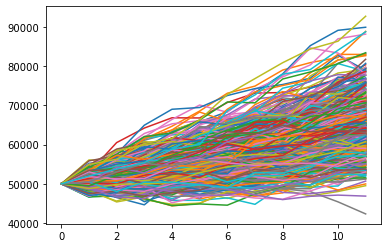

In [37]:
#plot the new results. 

simulate_return(annual_ret,annual_std,portfolio_income,new_time_horizon_quarters,500,investment_value).plot(legend = None)

In [38]:
# Creates a new variable for the end values of the new simulation

ending_values_2 = simulate_return(annual_ret,annual_std,portfolio_income,new_time_horizon_quarters,500,investment_value).tail(1)

# Organizes ending values into one column with Trial as the index

ending_values_2 = ending_values_2.T
ending_values_2['trial'] = 2
ending_values_2.columns = ['Ending Values', 'Trial']
ending_values_2.set_index('Trial')

,Ending Values
Trial,
2,77413.051421
2,64068.590950
2,55259.882285
2,73902.406050
2,66262.503142
...,...
2,75099.135842
2,56195.170231
2,61510.292734


In [39]:
# joins the ending values for trial 1 and trial 2 into one dataframe

two_trial_df = pd.concat([ending_values_1,ending_values_2])
two_trial_df.set_index('Trial')

,Ending Values
Trial,
1,82645.628046
1,69507.466194
1,75074.378290
1,82614.465585
1,68258.299464
...,...
2,75099.135842
2,56195.170231
2,61510.292734


In [40]:
# determines the minimum and maximum ending values for both simulations. This range will be used to scale the hvplot below.

min_val_1 = ending_values_1['Ending Values'].min()
min_val_2 = ending_values_2['Ending Values'].min()
max_val_1 = ending_values_1['Ending Values'].max()
max_val_2 = ending_values_2['Ending Values'].max()
max_val = max(max_val_1, max_val_2)
min_val = min(min_val_1,min_val_2)

In [41]:
# a distribution plot with slider to switch between trial 1 and 2

two_trial_df.hvplot.hist(
    bins=30,
    groupby="Trial",
    xlim = (min_val, max_val),
    size=(35, 7)
).opts(xformatter='%.0f')

:DynamicMap   [Trial]
   :Histogram   [Ending Values]   (Ending Values_count)

In [42]:
change_investment_size = input("""Given your new time horizon, would you like to change the initial investment size? If yes, enter the new starting value.
""")

Given your new time horizon, would you like to change the initial investment size? If yes, enter the new starting value.
 75000


In [43]:
# changes new investment amount into an integer

change_investment_size = int(change_investment_size)

In [44]:
# Creates a new variable for the end values of the third simulation

ending_values_3 = simulate_return(annual_ret,annual_std,portfolio_income,new_time_horizon_quarters,500,change_investment_size).tail(1)

# Organizes ending values into one column. Sets Trial as index.

ending_values_3 = ending_values_3.T
ending_values_3['trial'] = 3
ending_values_3.columns = ['Ending Values', 'Trial']
ending_values_3.set_index('Trial')

,Ending Values
Trial,
3,102819.672667
3,95782.927404
3,94964.976910
3,92578.278331
3,78733.156048
...,...
3,99942.073526
3,97660.417241
3,94414.506688


In [45]:
# joins the ending values for all three simulations into one dataframe

three_trial_df = pd.concat([two_trial_df,ending_values_3])
three_trial_df.set_index('Trial')

,Ending Values
Trial,
1,82645.628046
1,69507.466194
1,75074.378290
1,82614.465585
1,68258.299464
...,...
3,99942.073526
3,97660.417241
3,94414.506688


In [46]:
# determines the minimum and maximum ending values for both simulations. This range will be used to scale the hvplot below.

min_val_1 = ending_values_1['Ending Values'].min()
min_val_2 = ending_values_2['Ending Values'].min()
min_val_3 = ending_values_3['Ending Values'].min()
max_val_1 = ending_values_1['Ending Values'].max()
max_val_2 = ending_values_2['Ending Values'].max()
max_val_3 = ending_values_3['Ending Values'].max()
max_val = max(max_val_1, max_val_2, max_val_3)
min_val = min(min_val_1,min_val_2,min_val_3)

In [47]:
# a distribution plot with slider to switch between trial 1 2 and 3 

three_trial_df.hvplot.hist(
    bins=30,
    groupby="Trial",
    xlim = (min_val, max_val),
    size=(35, 7)
).opts(xformatter='%.0f')

:DynamicMap   [Trial]
   :Histogram   [Ending Values]   (Ending Values_count)

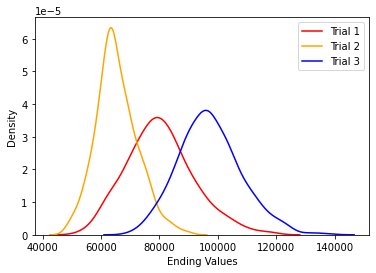

In [50]:
# another visualization of the distribution of each of the three trials using seaborn's kdeplot

ax = sns.kdeplot(ending_values_1['Ending Values'],color = 'red')
sns.kdeplot(ending_values_2['Ending Values'],color = 'orange')
sns.kdeplot(ending_values_3['Ending Values'],color = 'blue')
ax.legend(["Trial 1", "Trial 2", "Trial 3"])

In [ ]:
# Next potential steps - potentially allow user to change equity preference or implement user toggles in dashboard

In [ ]:
# Interactive Dashboard. Work still in progress.

In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px
import plotly.graph_objs as go
import flask
from dash.dependencies import Input, Output


In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

server = flask.Flask(__name__) # define flask app.server

app = dash.Dash(__name__, external_stylesheets=external_stylesheets, server=server) # call flask server

df = pd.DataFrame(simulate_return(annual_ret,annual_std,portfolio_income,simulated_quarters,500,investment_value))
df.reset_index(inplace=True)
df1 = df.rename(columns = {'index':'quarters'})
df2 = pd.melt(df1, id_vars='quarters', value_vars=df1.columns[:-1])
fig = px.line(df2, x="quarters", y="value", color ="variable")

app.layout = html.Div(children=[
    html.H1(children='Monte Carlo simulations', 
            style={'textAlign': 'center'}), 
        #html.Div(html.Ul(id='tickers',
            #children=[html.Li(i) for i in tickers],
            #style={'textAlign': 'center'})), 
        dcc.Graph(
            id='Monte Carlo simulations',
            figure=fig),

        html.Label('Investment Strategy for Equity'),
        dcc.Dropdown(
            id='equity_strategy',
            options=[
                {'label': 'Dividend Income', 'value': 1},
                {'label': 'Capital Growth', 'value': 2},
                {'label': 'Balanced', 'value': 3}
                 ],
            value=[1, 2, 3],
            multi=False
        ),

])

app.callback(
    Output('indicator-graphic', 'figure'),
    Input('equity_strategy', 'value'),
)

def update_graph(equity_strategy):
    equity_tickers = []

    if equity_strategy == 1:
        equity_tickers = tickers_equity_type1  
        equity_income = tickers_equity_type1_inc
    
    elif equity_strategy == 2:
        equity_tickers = tickers_equity_type2 
        equity_income = tickers_equity_type2_inc
    
    elif equity_strategy == 3:
        equity_tickers = tickers_equity_type3 
        equity_income = tickers_equity_type3_inc
    
    tickers = equity_tickers + fixed_income_tickers

    prices_df = alpaca.get_barset(
        tickers,
        timeframe,
        start=start_date,
        end=end_date,
        limit=limit_rows
    ).df

    MC_even_weight = MCSimulation(
        portfolio_data = prices_df,
        weights = weights,
        num_simulation = 500,
        num_trading_days = num_trading_days
    )

    sim_df = MC_even_weight.calc_cumulative_return()
    shift_df = sim_df.shift(-1)
    returns_df = (shift_df - sim_df) / sim_df
    annual_std_list = returns_df.std() * (252 **0.5)
    annual_std = annual_std_list.mean()
    annual_ret_list = returns_df.mean() * 252
    annual_ret = annual_ret_list.mean()
    fig.simulate_return(annual_ret,annual_std,portfolio_income,simulated_quarters,500,investment_value).plot(figsize = (20,12), legend=None)

    return fig


if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)